# AI Generated Text Detection with DistilBert

In [1]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import gc

## Distribution Strategy

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Configuration

In [3]:
class CFG:
    batch_size = strategy.num_replicas_in_sync * 16 if strategy.num_replicas_in_sync != 1 else 128
    sequence_length = 128
    is_training = False

## Load data

In [4]:
train_essay = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Actual-Datasets\train_essays.csv")
test_essay = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Actual-Datasets\test_essays.csv")
ai_df = train_essay[train_essay['generated']==1]
df = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Extra-Datasets-Used\Training_Essay_Data.csv")

In [5]:
df2 = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Extra-Datasets-Used\train_drcat_04.csv")
df2 = df2[['text','label']]
df2.columns = ['text','generated']

In [6]:
df3 = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Extra-Datasets-Used\train_essays_RDizzl3_seven_v1.csv")
df3.columns = ['text','generated']

In [7]:
train_data = pd.concat([df3,df2,df],axis=0,ignore_index=True)
train_data.drop_duplicates(inplace=True,ignore_index=True)

In [8]:
d1 = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Extra-Datasets-Used\falcon_180b_v1.csv")
d2 = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Extra-Datasets-Used\llama_70b_v1.csv")
data = pd.concat([d1,d2],axis=0,ignore_index=True)
data['generated'] = 1
data.columns = ['text','writing_prompt','generated']
data = data[['text','generated']]

In [9]:
Train_Data = pd.concat([train_data,data],axis=0,ignore_index=True)


In [10]:
d = pd.read_csv("D:\Downloads\LLM-Text-Detection-main\Extra-Datasets-Used\LLM_generated_essay_PaLM.csv")
d['generated'] = d['generated'].astype(int)
dd = d[['text','generated']]

In [11]:
Train_Data  =pd.concat([Train_Data,dd],axis=0,ignore_index=True)
Train_Data.drop_duplicates(inplace=True,ignore_index=True)

In [12]:
def balance_labels(df, label_column='generated'):
    label_counts=df[label_column].value_counts()
    max_count=label_counts.max()
    
    balanced_df=pd.DataFrame()
    
    for label, count in label_counts.items():
        label_subset = df[df[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)
        
    return balanced_df

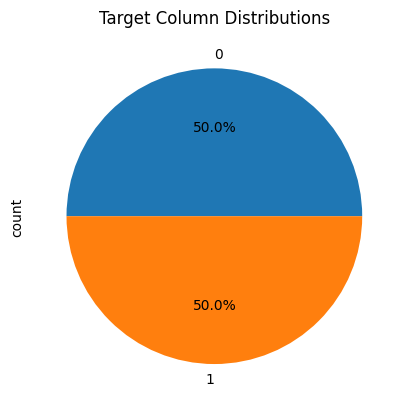

In [13]:
Train_Data=balance_labels(Train_Data)
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

In [14]:
train = Train_Data

In [15]:
train

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
82509,"As an eighth-grade student, I believe that try...",1
82510,"As an eighth-grade student, I believe that goi...",1
82511,"As an eighth-grade student, I believe that cre...",1
82512,"The famous artist Michelangelo once said, ""Th...",1


In [16]:
# train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
# train.head()

## Load Pretrained model

In [17]:
with strategy.scope():
    tokenizer = DistilBertTokenizer.from_pretrained(r"D:\Downloads\Distill Bert\tokenizer")
    encoder = TFDistilBertModel.from_pretrained(r"D:\Downloads\Distill Bert\encoder")
    gc.collect()

All model checkpoint layers were used when initializing TFDistilBertModel.

All the layers of TFDistilBertModel were initialized from the model checkpoint at D:\Downloads\Distill Bert\encoder.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [18]:
encoder.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


Let's learn about this pretrained model's input and output. When we past a text list to this pretrained model, it returns a dictionary with  key last_hidden_state.

In [19]:
# texts = ["hello world.", "how are you doing?"]
# text_preprocessed = tokenizer(
#     texts, 
#     max_length = CFG.sequence_length,
#     truncation=True, 
#     padding='max_length',
#     add_special_tokens=True,
#     return_tensors='tf'
# )
# print(text_preprocessed)
# output = encoder(text_preprocessed)
# output

## Text Preprocessing

In [20]:
def preprocess_data(df):
    return df

In [21]:
%%time
train = preprocess_data(Train_Data)
train.head()

CPU times: total: 0 ns
Wall time: 1.32 ms


,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


## 

## Create TensorFlow Dataset

In [22]:
def bert_encode(df, tokenizer):    
    texts = df['text'].tolist()
    tokens = tokenizer(
        texts, 
        max_length = CFG.sequence_length,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    if "generated" in df.keys():
        tokens["generated"] = df["generated"]
    return tokens

def preprocess(features):
    input_ids = features.pop("input_ids")
    attention_mask = features.pop("attention_mask")
    labels = features.pop("generated")
    return (input_ids, attention_mask), labels
def make_dataset(df, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices((df))
    if mode == "train":
        ds = ds.shuffle(256)
    ds = ds.batch(CFG.batch_size)
    ds = ds.map(preprocess)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [23]:
%%time
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=42)

CPU times: total: 0 ns
Wall time: 25.1 ms


In [24]:
%%time
if CFG.is_training:
    train_input = bert_encode(train_data, tokenizer)
    train_ds = make_dataset(train_input)
valid_input = bert_encode(valid_data, tokenizer)
valid_ds = make_dataset(valid_input, mode="valid")

CPU times: total: 2min 16s
Wall time: 2min 31s


Take a look at what training data looks like.

In [25]:
# for item in valid_ds.take(1):
#     print(item)

## Calcuate class weight

<Axes: xlabel='generated'>

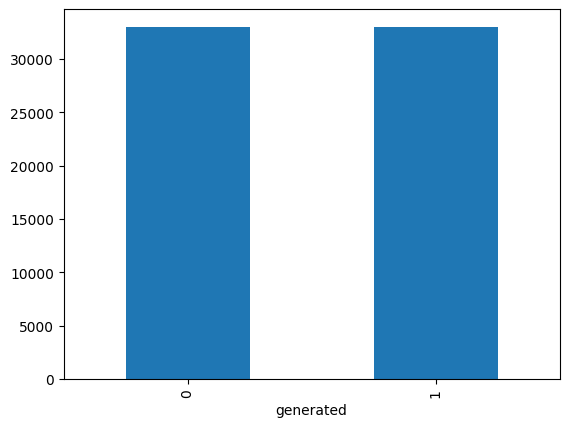

In [26]:
train_data["generated"].value_counts().plot(kind="bar")

In [27]:
class_weight = len(train_data["generated"]) / train_data["generated"].value_counts()
class_weight = dict(class_weight / class_weight.sum())
class_weight

{0: 0.4996439987274849, 1: 0.5003560012725152}

## Building Model

In [28]:
def build_model():
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")
    inputs = [input_ids, attention_mask]
    embedding = encoder(inputs)["last_hidden_state"]
    vector = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    output = tf.keras.layers.Dense(2, activation='softmax')(vector)
    auc = tf.keras.metrics.AUC(name="auc")
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy',auc])   
    return model

In [29]:
with strategy.scope():
    model = build_model()
    model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

C:\Users\91838\.conda\envs\myenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Training Model

In [30]:
with strategy.scope():
    if CFG.is_training:
        steps_per_epoch = train_data.shape[0] // CFG.batch_size
        validation_steps = valid_data.shape[0] // CFG.batch_size
        es = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            "model.h5", 
            monitor="val_accuracy", 
            save_best_only=True, 
            save_weights_only=True, 
            restore_best_weights=True
        )
        history = model.fit(
            train_ds, 
            epochs = 10, 
            steps_per_epoch = steps_per_epoch,
            validation_steps = validation_steps,
            validation_data=valid_ds,
            class_weight=class_weight,
            callbacks=[es, checkpoint]
        )
        pd.DataFrame(history.history).plot()
    else:
        model.load_weights(r"D:\Downloads\Distill Bert\model.h5")

## Evaluating model

In [31]:
%%time
y_pred = model.predict(valid_ds)[:, 1]
y_pred.shape

129/129 [==============================] - 143s 1s/step
CPU times: total: 1min 36s
Wall time: 2min 23s


(16503,)

In [35]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

# Assuming y_pred contains the model's raw predictions (probabilities)
y_pred_label = np.array(y_pred >= 0.5, dtype=float)  # Convert to binary labels

# Calculate additional metrics
auc = roc_auc_score(valid_data["generated"], y_pred)
acc = accuracy_score(valid_data["generated"], y_pred_label)
f1 = f1_score(valid_data["generated"], y_pred_label)
precision = precision_score(valid_data["generated"], y_pred_label)
recall = recall_score(valid_data["generated"], y_pred_label)

print(f"AUC score: {auc}")
print(f"Accuracy score: {acc}")
print(f"F1 score: {f1}")
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")


AUC score: 0.3504295332274879
Accuracy score: 0.42234745197842816
F1 score: 0.5285594184263884
Precision score: 0.4473463920977733
Recall score: 0.6458006042296073


## Create Submission file

In [33]:
# test = pd.read_csv(r"D:\Downloads\LLM-Text-Detection-main\Actual-Datasets\test_essays.csv")
# test = preprocess_data(test)
# test_input = bert_encode(test, tokenizer)
# test_ds = tf.data.Dataset.from_tensor_slices(
#     (
#         (
#             test_input["input_ids"], 
#             test_input["attention_mask"]
#         ), 
#         np.zeros(len(test))
#     )
# ).batch(128).prefetch(tf.data.AUTOTUNE)
# predictions = model.predict(test_ds)[:, 1]
# test['generated'] = predictions
# submission = test[["id", "text","generated"]]
# submission.to_csv("submission.csv", index = False)
# submission.head()

In [34]:
# model.save("model-distillbert")